In [1]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from functools import partial
from itertools import chain, combinations, islice, product
import networkx as nx
import pandas
import random
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns

random.seed(1337)
np.random.seed(1337)

plt.rc('figure',facecolor='w')
plt.rc('svg',fonttype='none')

In [2]:
gsea_cat = pandas.read_csv('gsea_category_map.csv',index_col=0)

In [3]:
from cluster_graph import cluster_gsea, shortened_geneset_names, union_leadingEdge

No surviving genesets to cluster


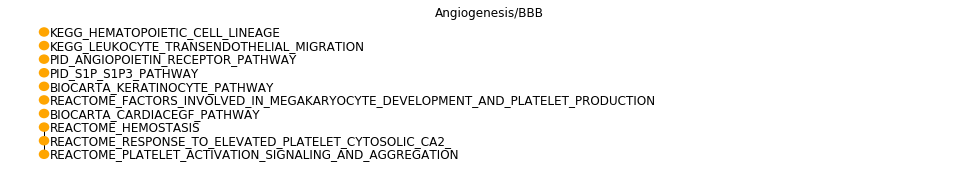

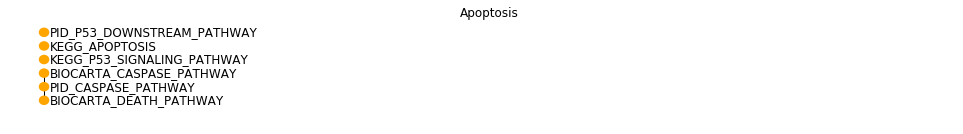

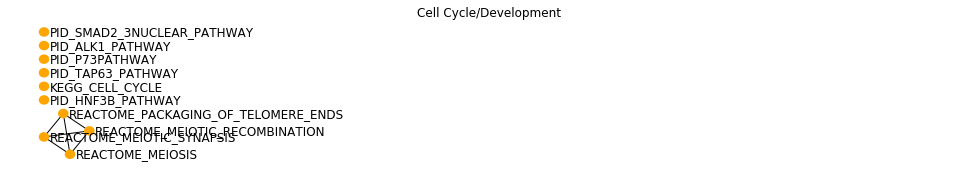

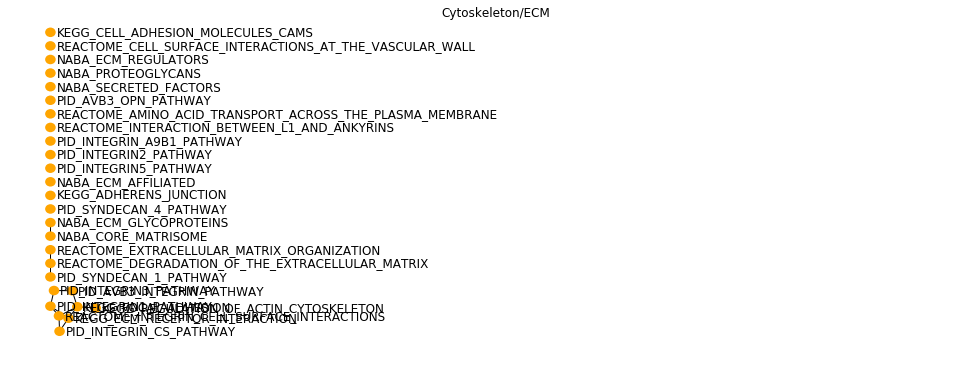

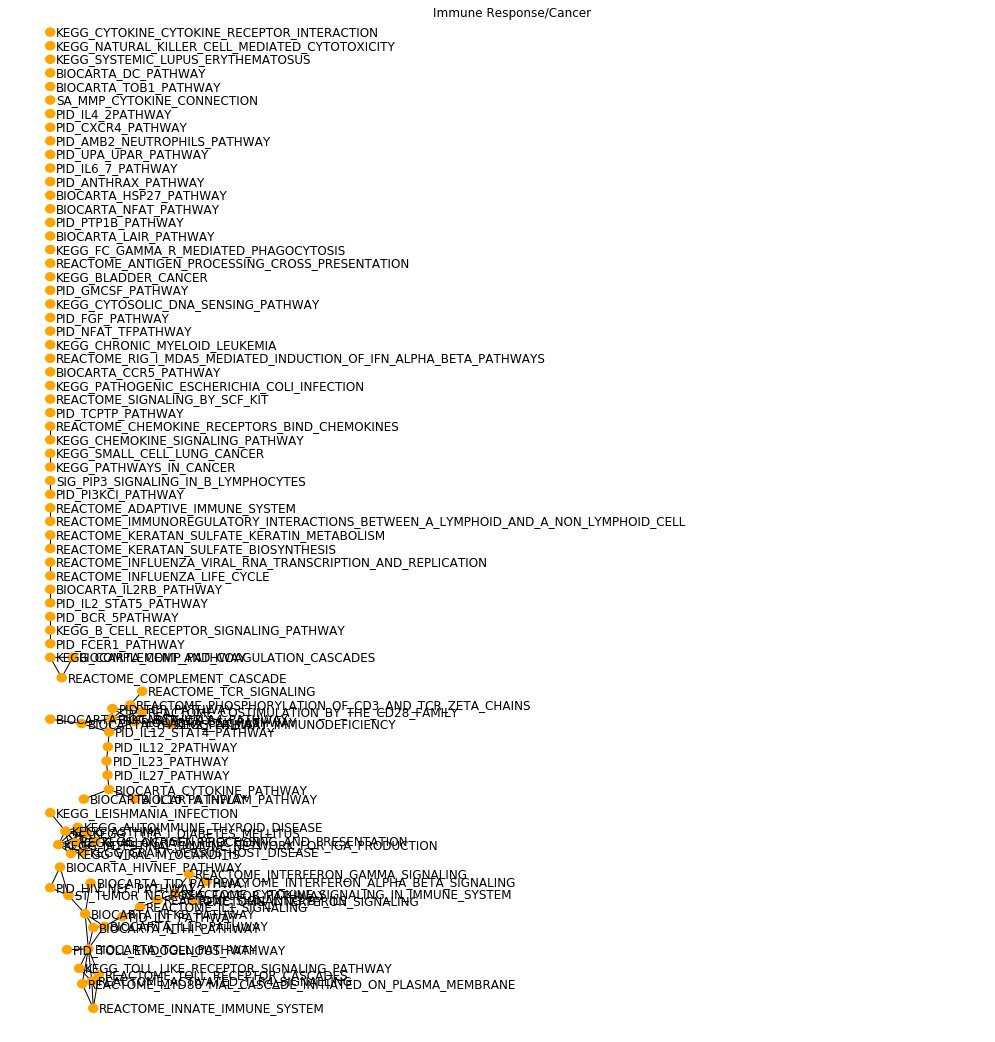

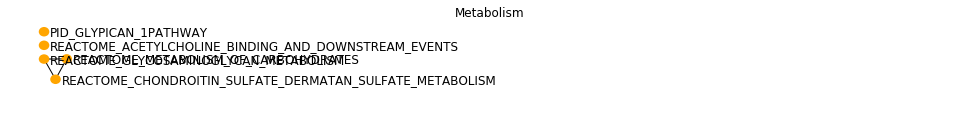

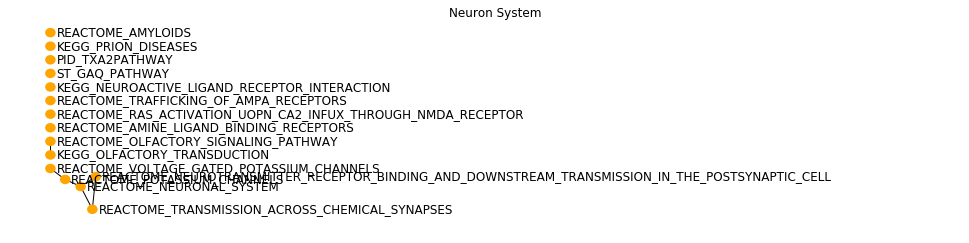

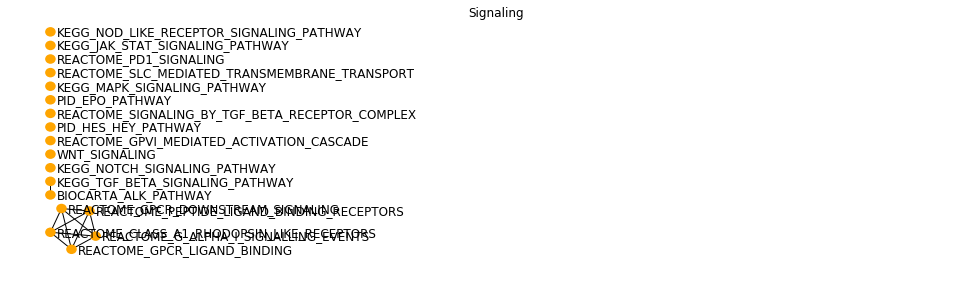

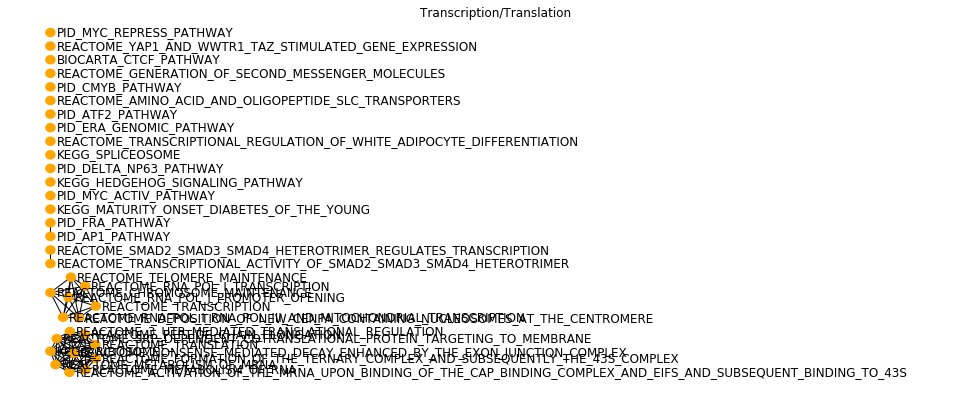

In [4]:
hd_ba9_gsea = pandas.read_csv('sympBA9_deseq2_fgsea_halfzero.csv',index_col=0)
hd_ba9_gsea = hd_ba9_gsea.merge(gsea_cat,left_index=True,right_index=True,how='left')
for category, gsea in hd_ba9_gsea.groupby('Category') :
    sig_gsea = gsea[gsea.padj<0.05]
    if sig_gsea.size == 0 :
        print('No significant gene sets for category {}'.format(category))
    else :
        cat = category.lower().replace('/','_').replace(' ','_')
        f = cluster_gsea(sig_gsea,jacc_thresh=0.25)
        if f :
            f.gca().set_title(category)
            f.savefig('sympBA9_deseq2_fgsea_halfzero_c2cp_{}.svg'.format(cat))
hd_ba9_gsea.columns = ['hdba9_{}'.format(_) for _ in hd_ba9_gsea.columns]

No surviving genesets to cluster
No surviving genesets to cluster
No surviving genesets to cluster
No significant gene sets for category Metabolism
No significant gene sets for category Protein Folding/Other
No surviving genesets to cluster


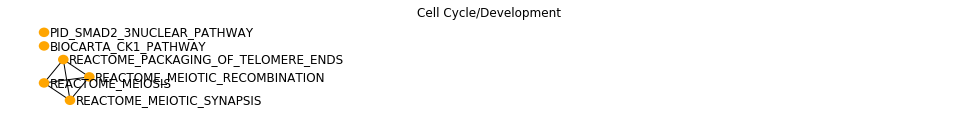

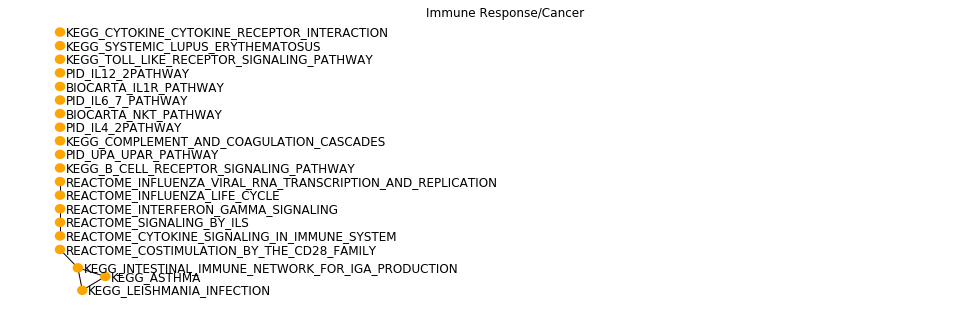

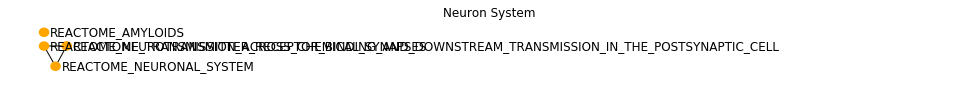

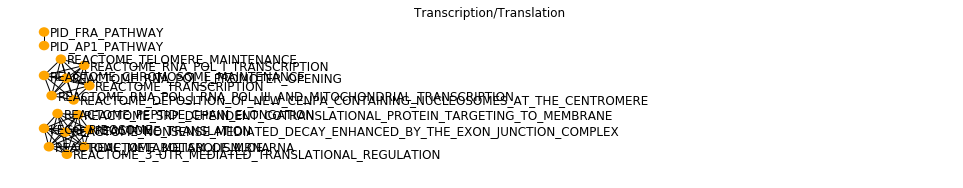

In [5]:
hdpos_ba9_gsea = pandas.read_csv('asymp_C_deseq2_fgsea_halfzero.csv',index_col=0)
hdpos_ba9_gsea = hdpos_ba9_gsea.merge(gsea_cat,left_index=True,right_index=True,how='left')
for category, gsea in hdpos_ba9_gsea.groupby('Category') :
    sig_gsea = gsea[gsea.padj<0.05]
    if sig_gsea.size == 0 :
        print('No significant gene sets for category {}'.format(category))
    else :
        cat = category.lower().replace('/','_').replace(' ','_')
        f = cluster_gsea(sig_gsea,jacc_thresh=0.25)
        if f :
            f.gca().set_title(category)
            f.savefig('sympBA9_deseq2_fgsea_halfzero_c2cp_{}.svg'.format(cat))
hdpos_ba9_gsea.columns = ['hdposba9_{}'.format(_) for _ in hdpos_ba9_gsea.columns]

No significant gene sets for category Angiogenesis/BBB
No significant gene sets for category Apoptosis
No significant gene sets for category Cell Cycle/Development
No surviving genesets to cluster
No surviving genesets to cluster
No significant gene sets for category Metabolism
No significant gene sets for category Protein Folding/Other
No surviving genesets to cluster
No surviving genesets to cluster


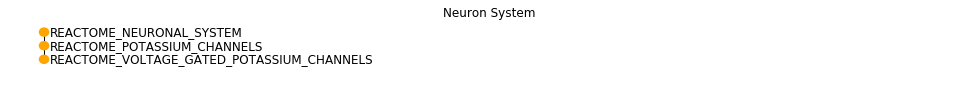

In [6]:
hdpos_cau_gsea = pandas.read_csv('asymp_deseq2_fgsea_lessthan4zero.csv',index_col=0)
hdpos_cau_gsea = hdpos_cau_gsea.merge(gsea_cat,left_index=True,right_index=True,how='left')
for category, gsea in hdpos_cau_gsea.groupby('Category') :
    sig_gsea = gsea[gsea.padj<0.05]
    if sig_gsea.size == 0 :
        print('No significant gene sets for category {}'.format(category))
    else :
        cat = category.lower().replace('/','_').replace(' ','_')
        f = cluster_gsea(sig_gsea,jacc_thresh=0.25)
        if f :
            f.gca().set_title(category)
            f.savefig('sympCAU_deseq2_fgsea_halfzero_c2cp_{}.svg'.format(cat))
hdpos_cau_gsea.columns = ['hdposcau_{}'.format(_) for _ in hdpos_cau_gsea.columns]

No significant gene sets for category Apoptosis
No significant gene sets for category Cell Cycle/Development
No surviving genesets to cluster
No surviving genesets to cluster
No significant gene sets for category Protein Folding/Other
No significant gene sets for category Transcription/Translation


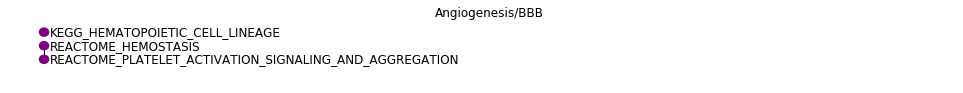

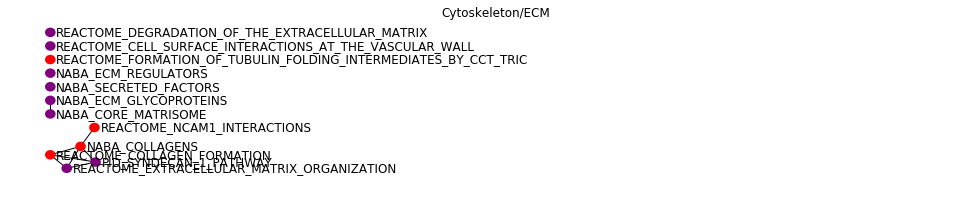

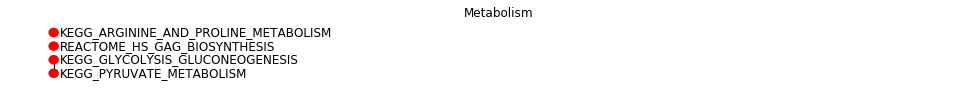

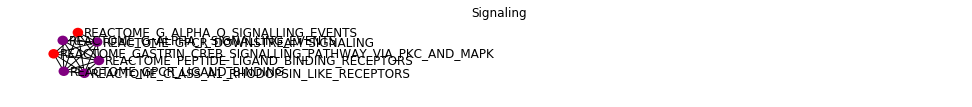

In [7]:
effect = pandas.read_csv('ttest_GTEx_asymptomatic_effect_c2cp.csv',index_col=0)
effect = effect.merge(gsea_cat,left_index=True,right_index=True,how='left')
effect_cm = dict(zip(effect.index,['red']*len(effect.index)))
for i in effect.index.intersection(hd_ba9_gsea[hd_ba9_gsea.hdba9_padj<0.05].index) :
    effect_cm[i] = 'purple'
for category, gsea in effect.groupby('Category') :
    sig_gsea = gsea[gsea.padj<0.05]
    if sig_gsea.size == 0 :
        print('No significant gene sets for category {}'.format(category))
    else :
        cat = category.lower().replace('/','_').replace(' ','_')
        f = cluster_gsea(sig_gsea,jacc_thresh=0.25, colormap=effect_cm)
        if f :
            f.gca().set_title(category)
            f.savefig('ttest_GTEx_asymptomatic_effect_c2cp_{}.svg'.format(cat))
effect.columns = ['effect_{}'.format(_) for _ in effect.columns]

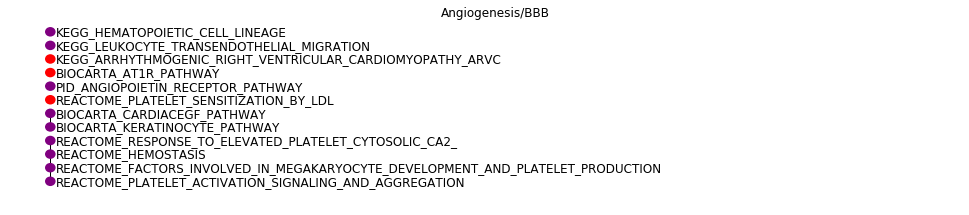

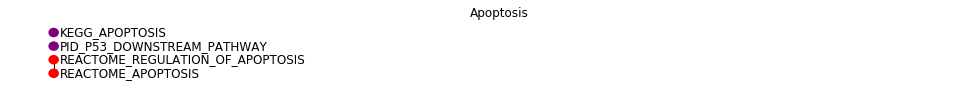

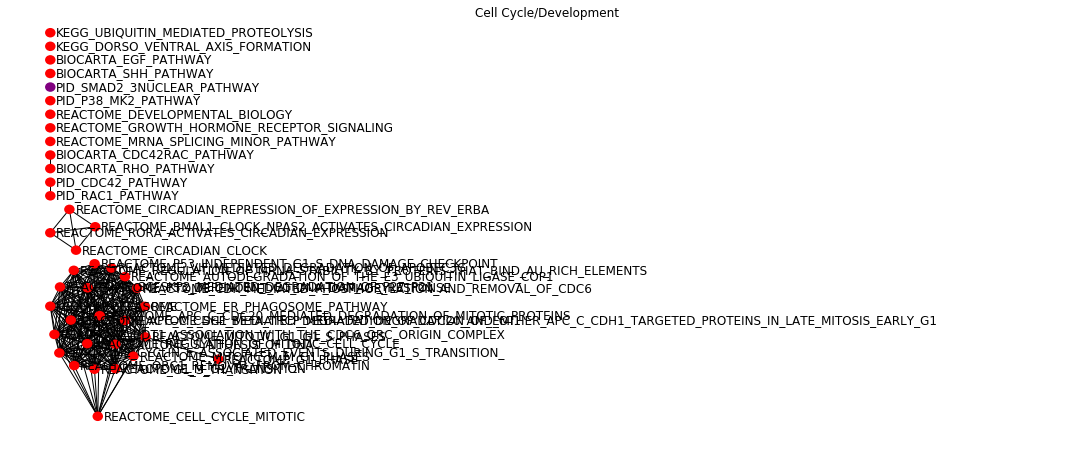

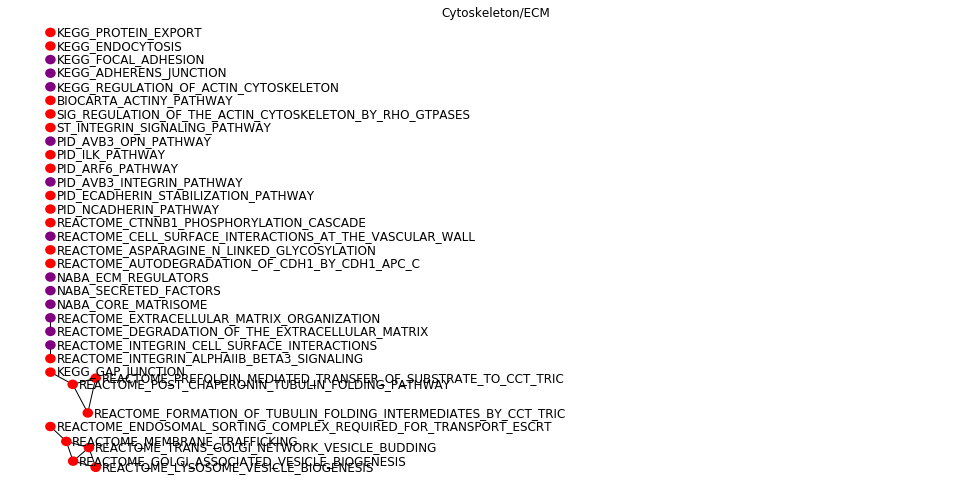

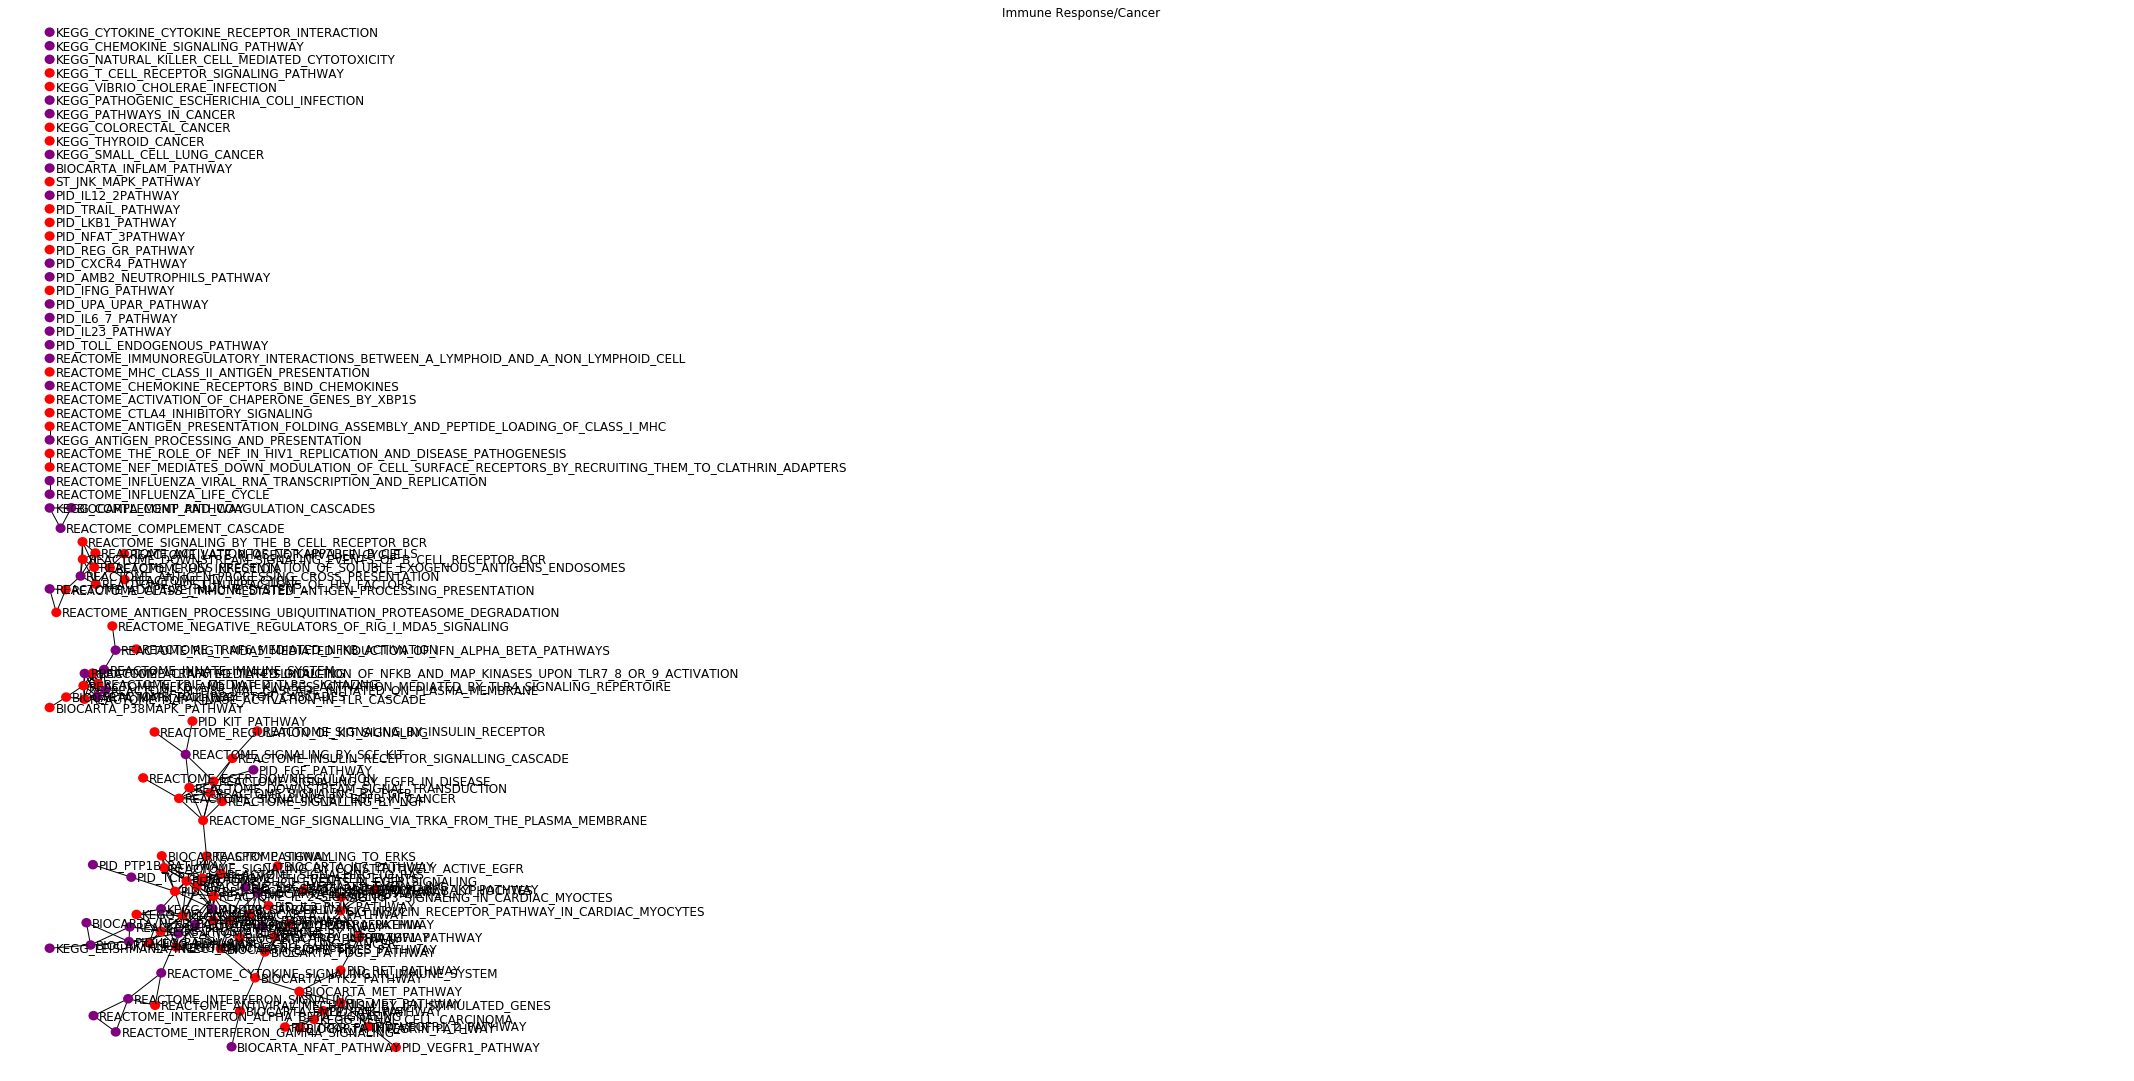

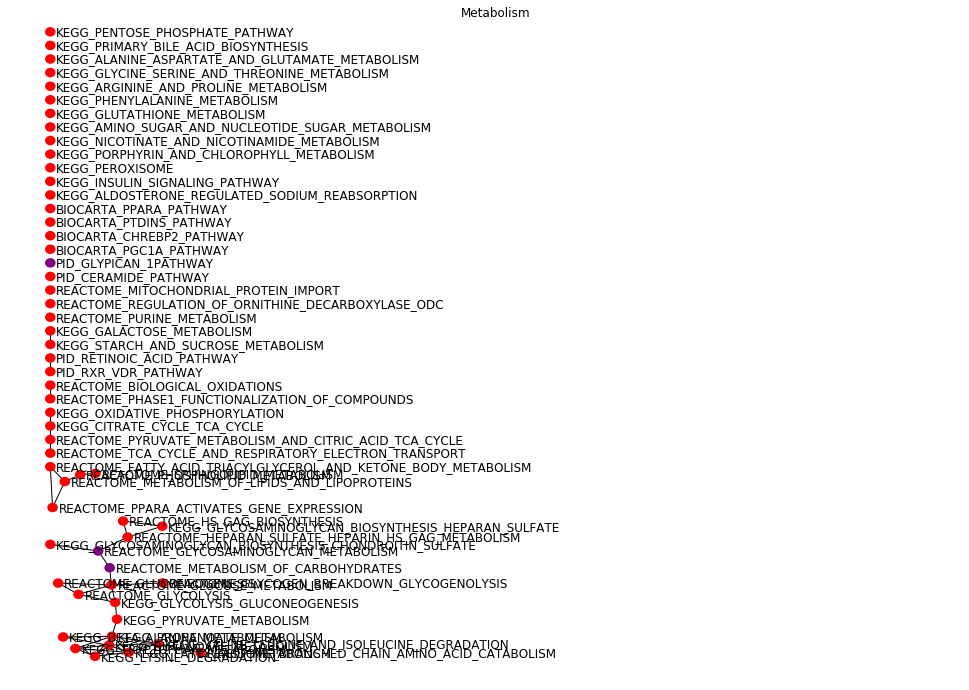

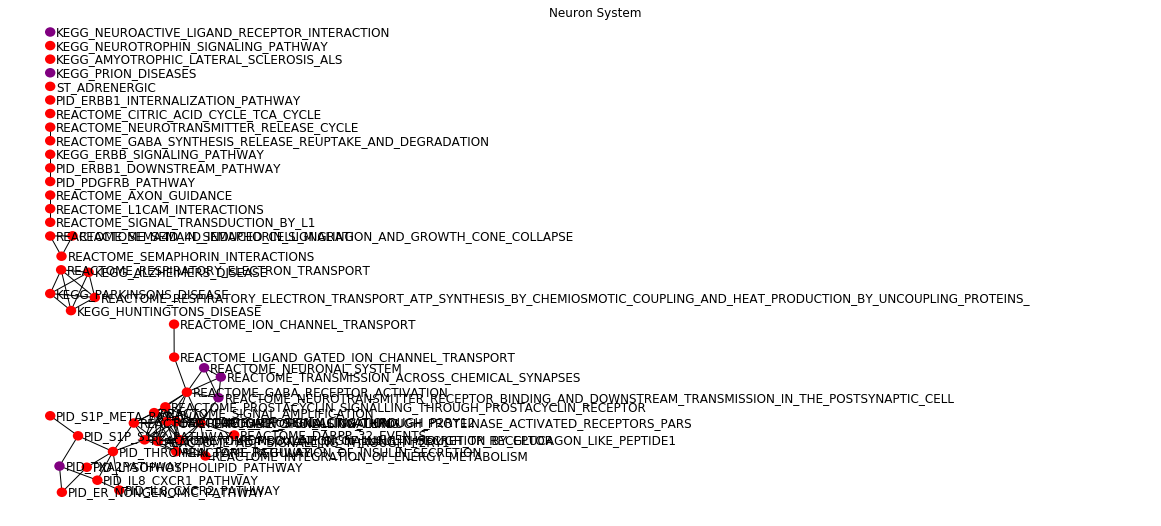

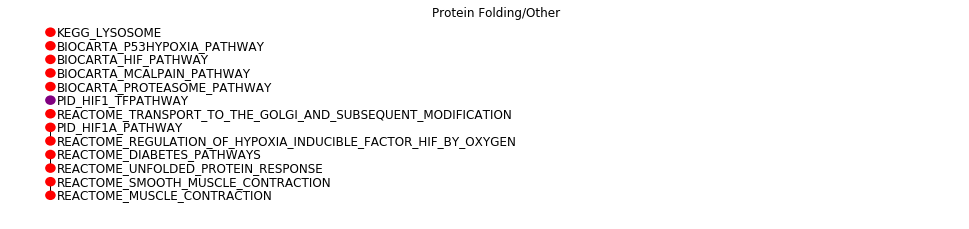

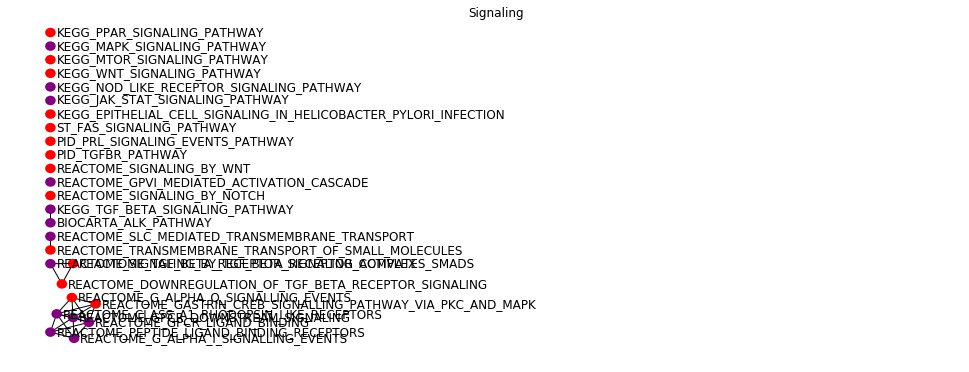

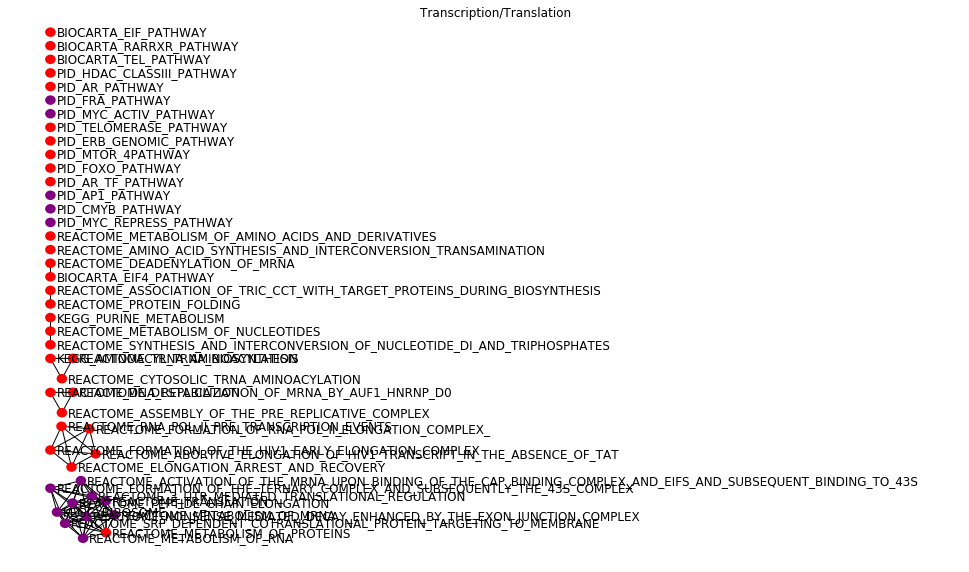

In [8]:
direct = pandas.read_csv('ttest_GTEx_asymptomatic_direct_c2cp.csv',index_col=0)
direct = direct.merge(gsea_cat,left_index=True,right_index=True,how='left')
direct.name = 'direct'
direct_cm = dict(zip(direct.index,['red']*len(direct.index)))
for i in effect.index.intersection(hd_ba9_gsea[hd_ba9_gsea.hdba9_padj<0.05].index) :
    direct_cm[i] = 'purple'
for category, gsea in direct.groupby('Category') :
    sig_gsea = gsea[gsea.padj<0.05]
    if sig_gsea.size == 0 :
        print('No significant gene sets for category {}'.format(category))
    else :
        cat = category.lower().replace('/','_').replace(' ','_')
        f = cluster_gsea(sig_gsea,jacc_thresh=0.25,colormap=direct_cm)
        if f :
            f.gca().set_title(category)
            f.savefig('ttest_GTEx_asymptomatic_effect_c2cp_{}.svg'.format(cat))
direct.columns = ['direct_{}'.format(_) for _ in direct.columns]

In [9]:
def region_leadingEdges(df) :
    # leading edge genes
    cap_leadingEdge = reduce_leadingEdge(
        df.direct_leadingEdge[
            (df.direct_padj<0.05) &
            (df.hdba9_padj>=0.05) &
            (df.hdposba9_padj>=0.05)
        ]
    )
        
    hdba9_leadingEdge = reduce_leadingEdge(
        df.hdba9_leadingEdge[
            (df.hdba9_padj<0.05) &
            (df.direct_padj>=0.05)
        ]
    )
    
    hdposba9_leadingEdge = reduce_leadingEdge(
        df.hdposba9_leadingEdge[
            (df.hdposba9_padj<0.05) &
            (df.direct_padj>=0.05)
        ]
    )
    return [cap_leadingEdge, hdba9_leadingEdge, hdposba9_leadingEdge]

def reduce_leadingEdge(leadingEdge) :
    if leadingEdge.size > 0 :
        return set(reduce(
            lambda x,y: set(x).union(set(y)),
            [_.split() for _ in leadingEdge]
        ))
    else :
       return set()
        

In [10]:
from functools import reduce
merged = reduce(
    lambda l,r: l.merge(r,left_index=True,right_index=True,how='outer'),
    [hd_ba9_gsea,hdpos_ba9_gsea,hdpos_cau_gsea, direct])

sig_merged = merged.loc[
    (merged.hdba9_padj<0.05) |
    (merged.hdposba9_padj<0.05) |
    (merged.hdposcau_padj<0.05) |
    (merged.direct_padj<0.05)
].copy()
sig_merged.loc[:,'Category'] = sig_merged.hdba9_Category

sig_merged.index = shortened_geneset_names(sig_merged)

/home/labadorf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/labadorf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/labadorf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

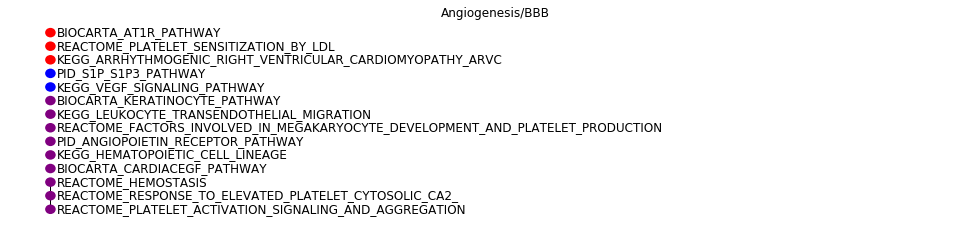

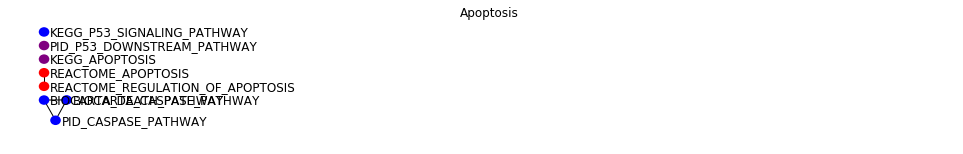

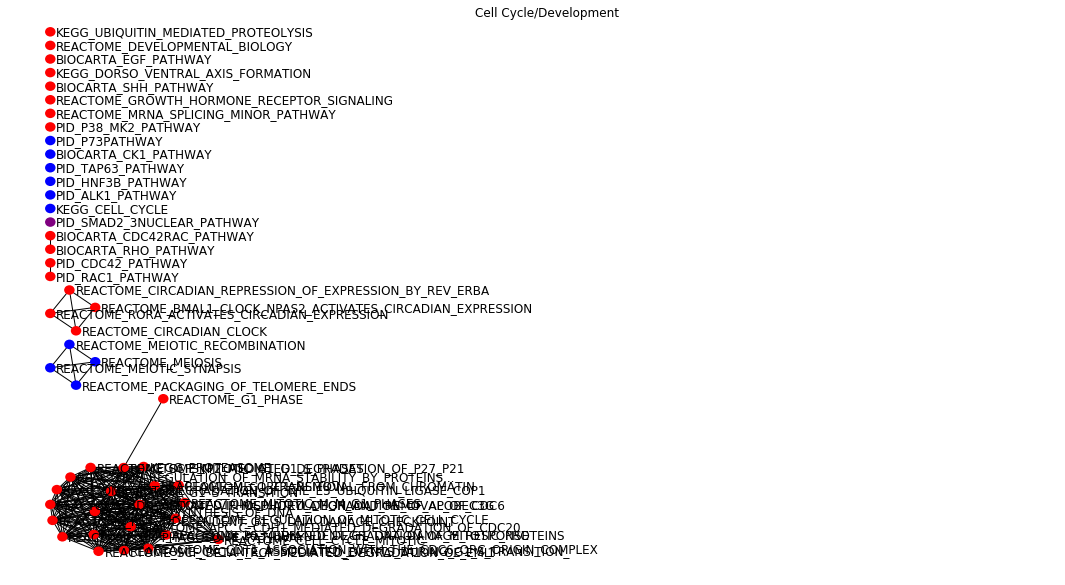

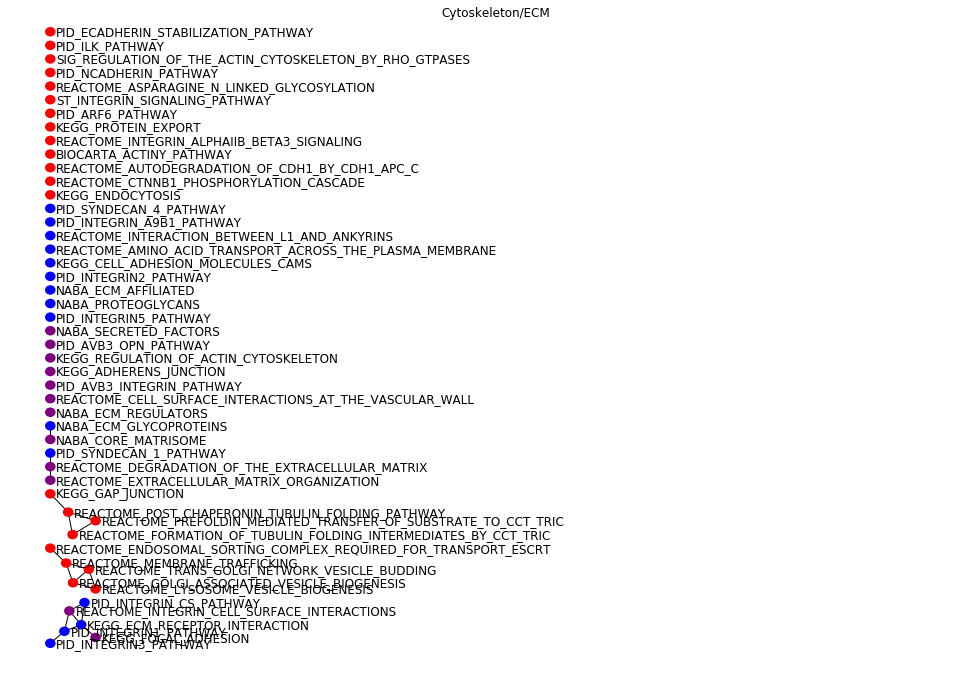

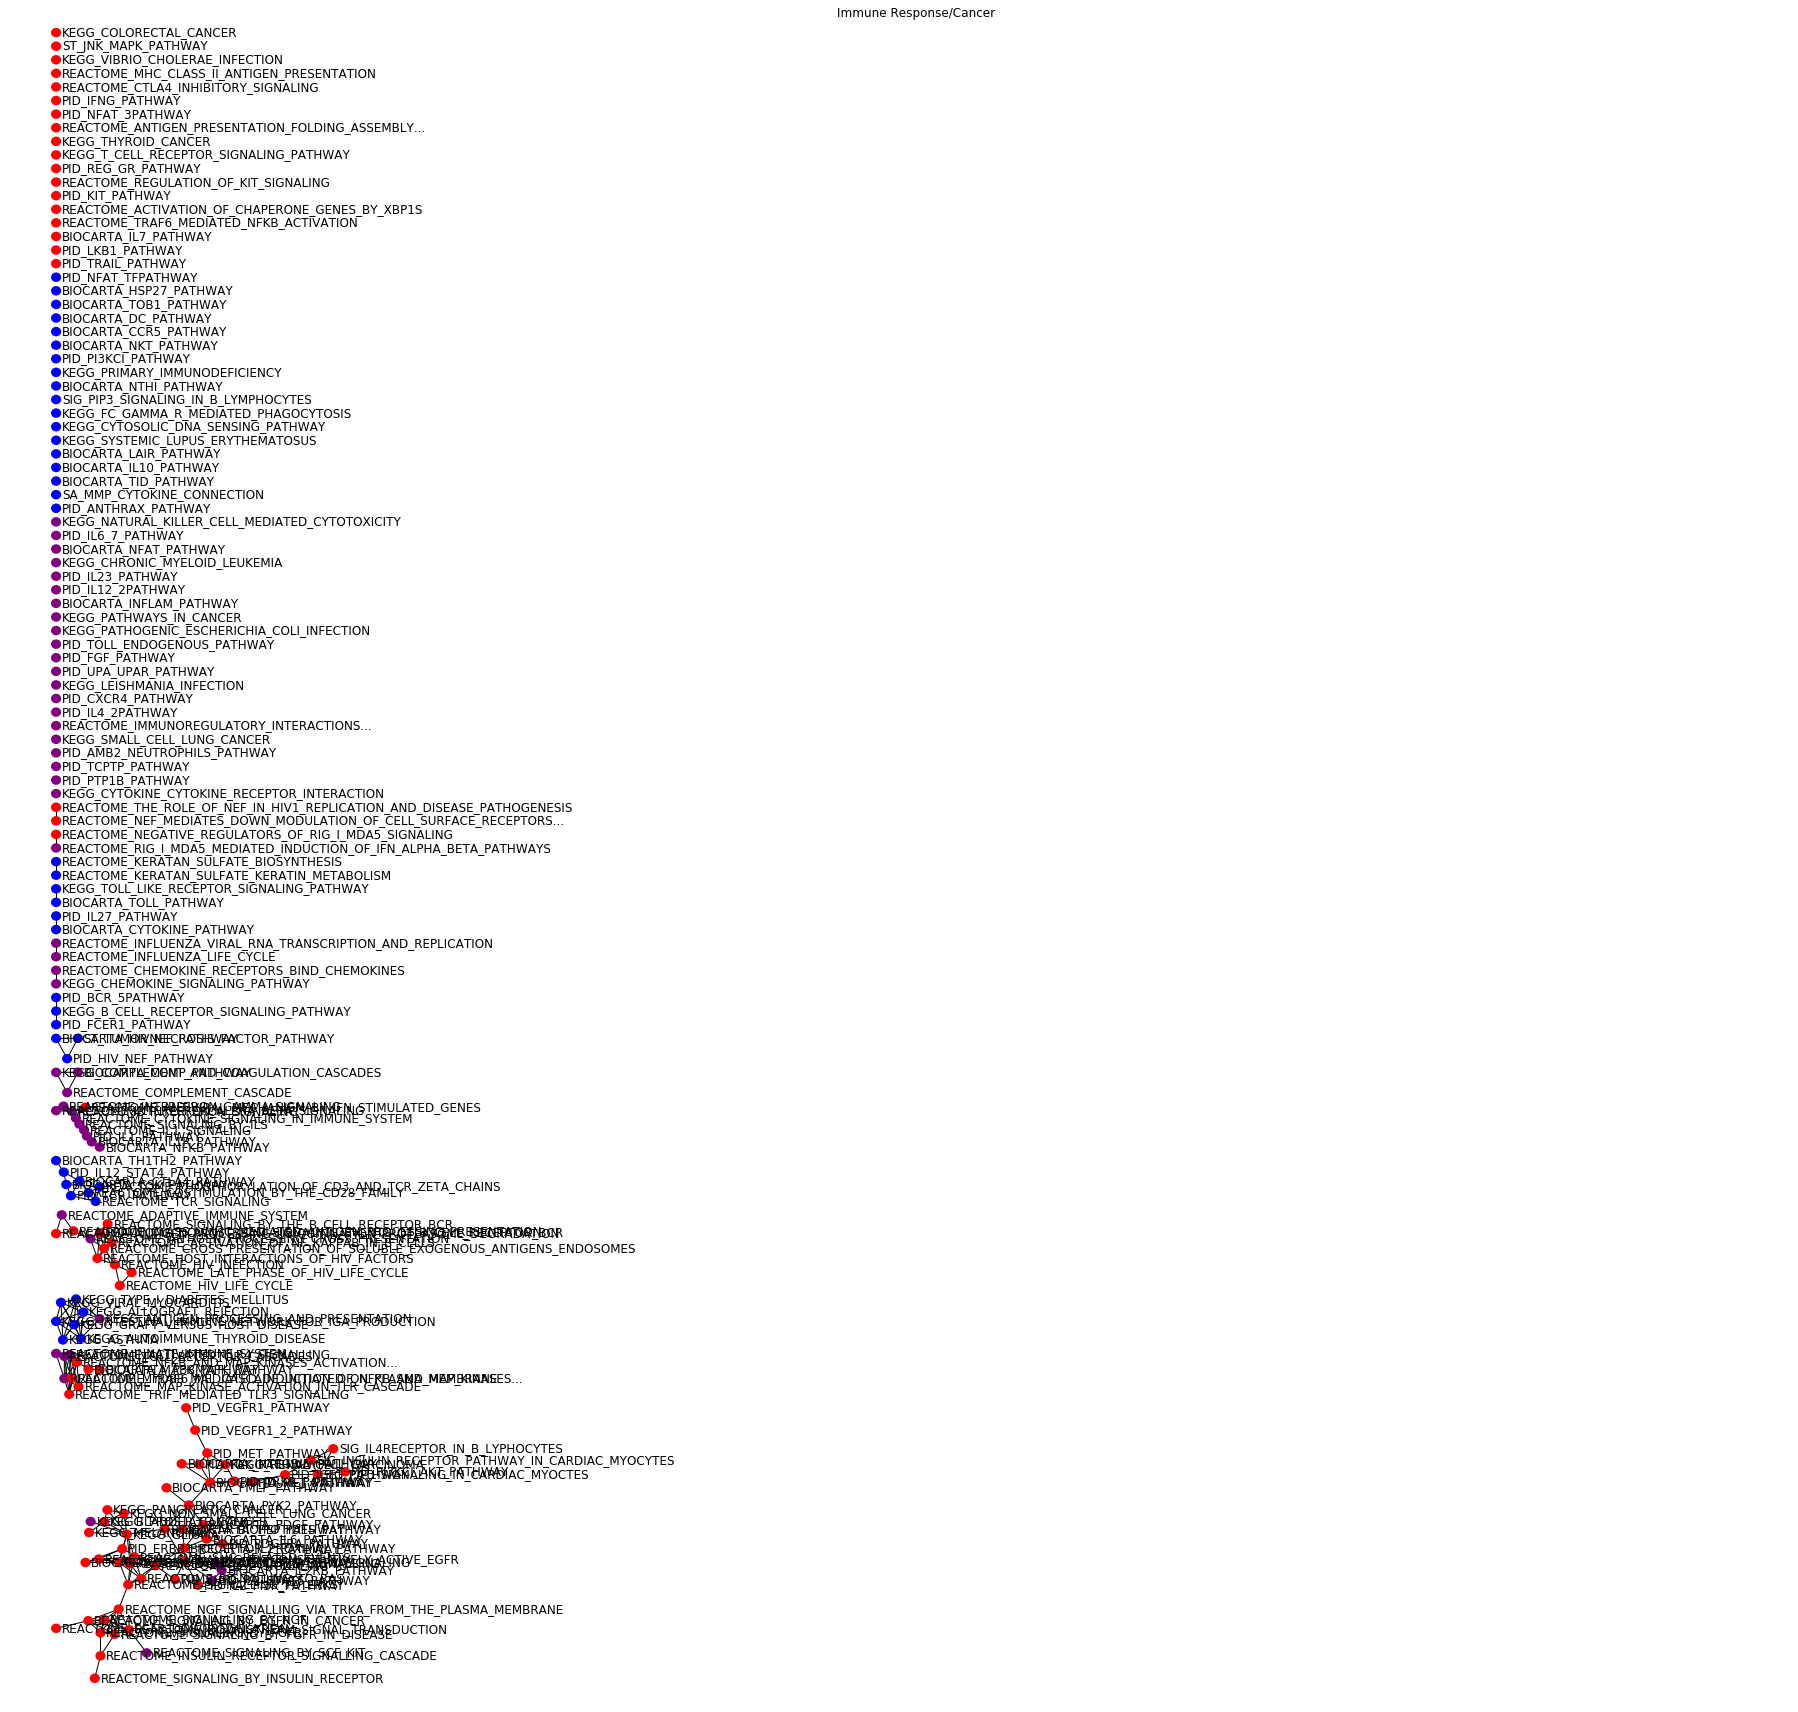

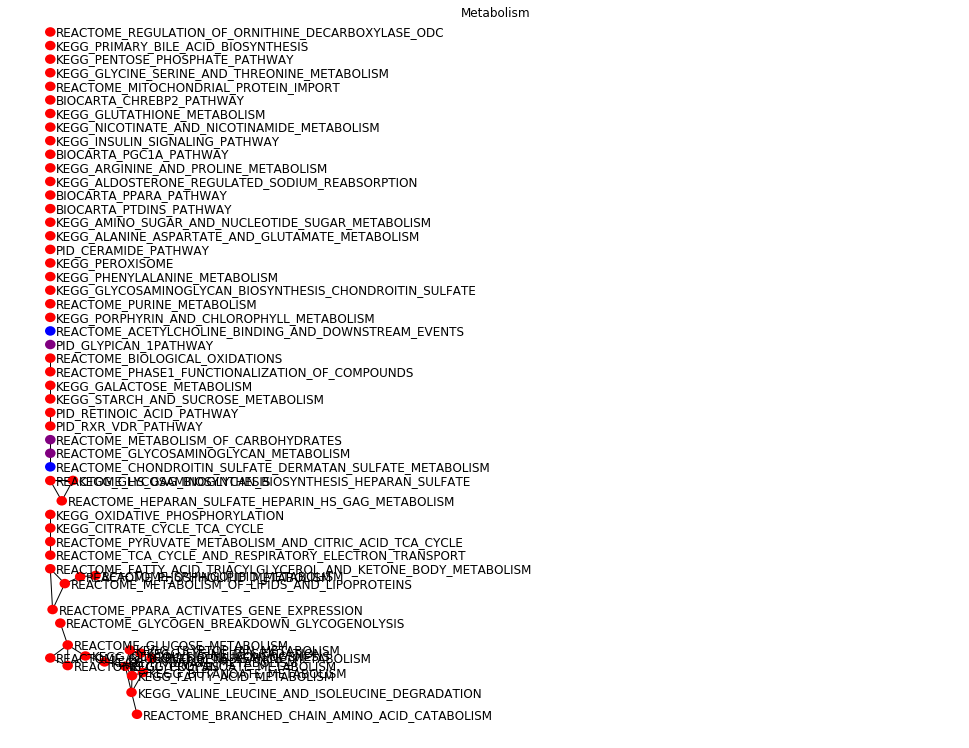

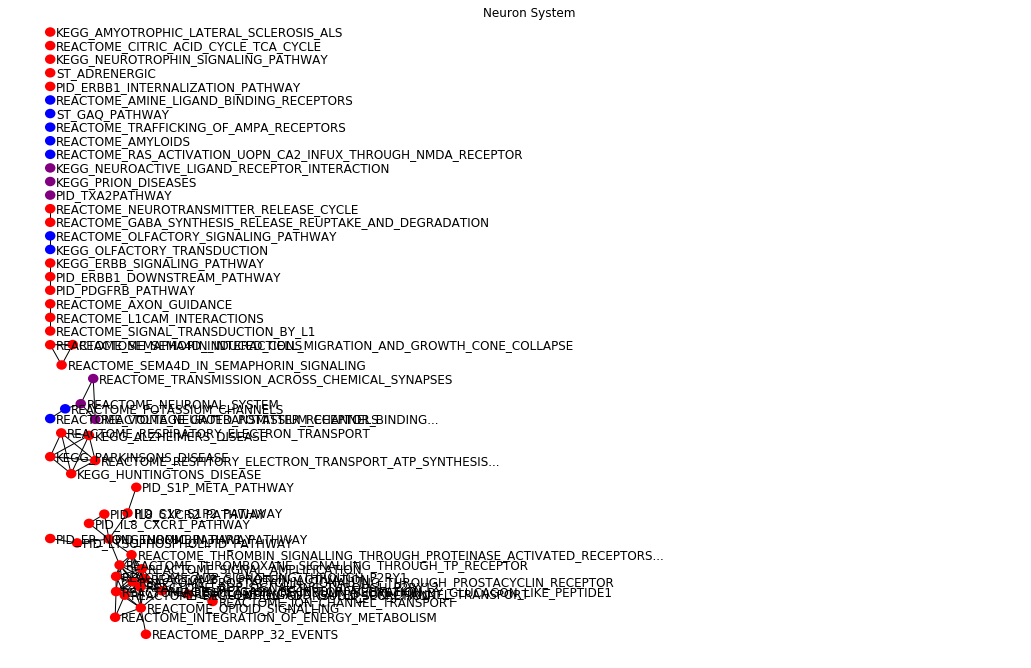

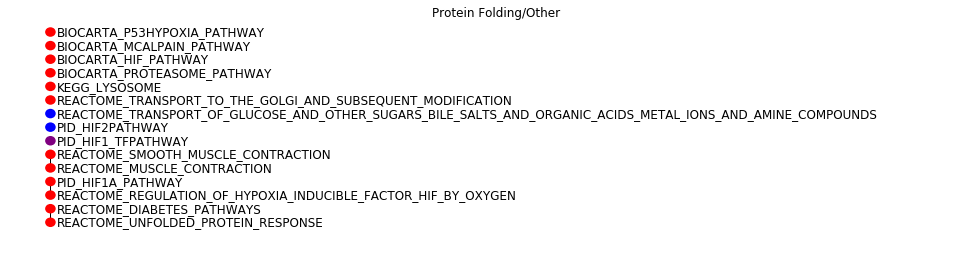

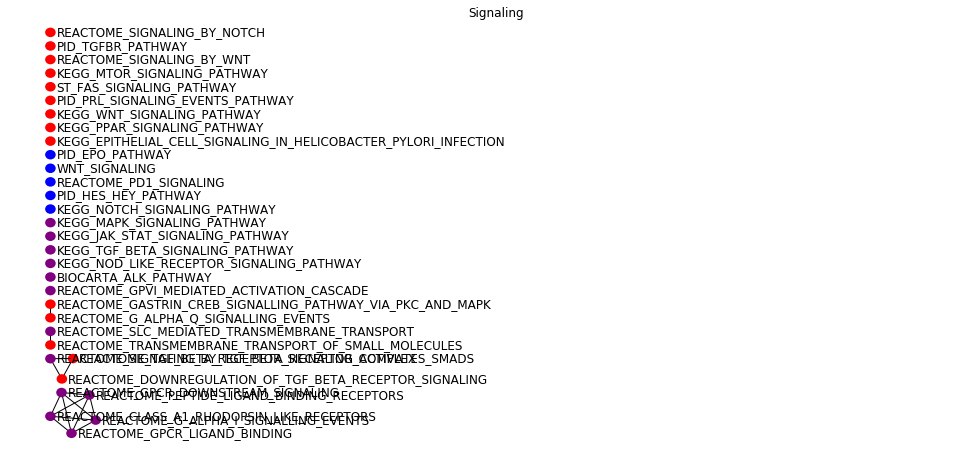

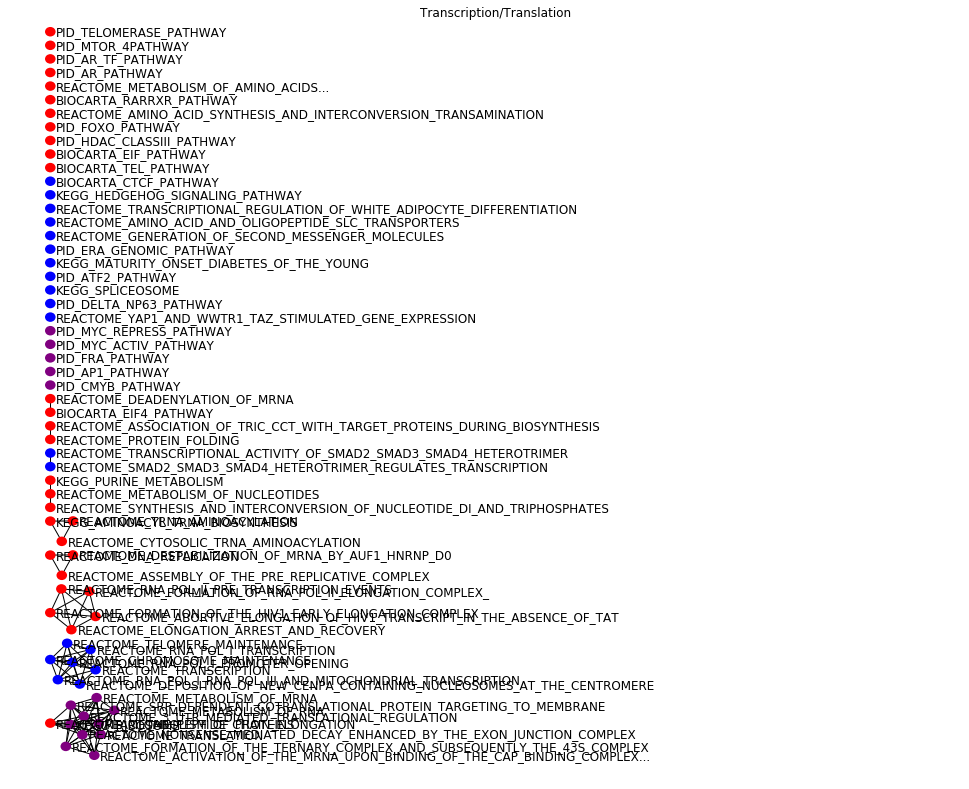

In [11]:
# graph of CAU vs BA9 and BA9 enriched genesets for different categories
cats = ['Cell Cycle/Development','Immune Response/Cancer']
for cat, df in sig_merged.groupby('Category') :
    #df = sig_merged.loc[sig_merged.Category == cat].copy()
    df['leadingEdge'] = ''

    cm = {}
    
    cap_sig = set(df[df.direct_padj<0.05].index)
    ba9_sig = set(df[df.hdba9_padj<0.05].index).union(
        set(df[df.hdposba9_padj<0.05].index)
    )

    # leading edge for CAU only is just from (3) vs (5)
    cau_df = df.loc[cap_sig.difference(ba9_sig)].copy()
    cau_df['leadingEdge'] = cau_df.direct_leadingEdge
    cm.update(dict(zip(cau_df.index,['red']*cau_df.index.size)))
    
    # leading edge for (1) or (2) is the union of those
    ba9_df = df.loc[ba9_sig.difference(cap_sig)].copy()
    ba9_df['leadingEdge'] = union_leadingEdge(ba9_df[['hdba9_leadingEdge','hdposba9_leadingEdge']])
    cm.update(dict(zip(ba9_df.index,['blue']*ba9_df.index.size)))
    
    # leading edge for all three is union of all
    all_df = df.loc[cap_sig.intersection(ba9_sig)]
    all_df['leadingEdge'] = union_leadingEdge(all_df)
    cm.update(dict(zip(all_df.index,['purple']*all_df.index.size)))
        
    # concatenate the back together, the indices should be disjoint
    all_df = pandas.concat([cau_df, ba9_df, all_df],axis=0)
    assert df.shape == all_df.shape
    
    f = cluster_gsea(all_df,colormap=cm)
    f.gca().set_title(cat)
    f.savefig('combined_gsea_clusters_{}.svg'.format(cat.lower().replace('/','_').replace(' ','_')))